# Assignment 4: Conjoint Analysis
The objective of this assignment is to give you experience with ratings-based conjoint analysis.

### Part 1: Study Design

In [19]:
# Import the experimental design builder script.
import sys
sys.path.insert(1, '/data/Assignment-4')
import designer
import pandas as pd
import numpy as np

In [20]:
import inspect

In [21]:
lines = inspect.getsource(designer)
print(lines)

import pickle
import pandas as pd
from collections import defaultdict

designs = pickle.load(open("/data/Assignment-4/designs.pkl", 'rb'))

def get_design(attributes):
    if len(attributes) > 6:
        raise ValueError("Too many attributes!")
    parameters = 1 + sum([len(levels) - 1 for levels in attributes.values()])
    if parameters > 13:
        raise ValueError("Too many parameters; fewer levels required.")
    min_levels = min([len(levels) for levels in attributes.values()])
    max_levels = max([len(levels) for levels in attributes.values()])
    if max_levels - min_levels > 2:
        raise ValueError("Differences in level numbers too large (cannot exceed 2).")

    sorted_attributes = tuple(sorted([len(levels) for levels in attributes.values()]))
    attribute_indices = sorted(range(len(sorted_attributes)),
                               key=lambda idx: [len(levels) for levels in attributes.values()][idx])
    if sorted_attributes not in designs:
        raise Error("No mat

**Task 1:** Define a variable called `attributes` that contains the attributes and levels within each attribute.  The viable shoukd be a dictionary where each attribute is a key and the value associated witht he key is a list of the levels.  For example, if the two attributes were color (with levels red and green) and shape (with levels round and square), then `attributes` would be defined as follows.

```
attributes = {"color": ["red", "green"],
             "shape": ["round", "square"]}
```

In [22]:
attributes = {"dairy": ["Yes", "No"],
             "size": ["11-Oz", "16.9-Oz"],
             "protein": ["Natural","Synthetic"]}

In [23]:
# Use the designer script to find a matching design.
design = designer.get_design(attributes)
design

,dairy,size,protein
0,Yes,16.9-Oz,Synthetic
1,No,16.9-Oz,Synthetic
2,Yes,11-Oz,Synthetic
3,Yes,11-Oz,Natural
4,No,11-Oz,Natural
5,No,16.9-Oz,Natural
6,No,11-Oz,Synthetic
7,Yes,16.9-Oz,Natural


### Parts 2 & 3: Write and administer the survey
**Task 2:** When you are done administering the survey:
- download CSV from qualtrics
- rename the file `survey.csv` and upload it here, and
- read the CSV file in as a pandas data frame called `raw_survey_results`.

In [24]:
raw_survey_results = pd.read_csv("survey.csv", header=1)

**Task 3:** Clean the data in preparation for analysis; name the clean data frame `clean_survey_results`.  You may need to do some or all of the following:
- remove rows and/or columns
- rename columns
- melt the data
- merge the data with the design data frame you created previously
The final data frame should have one row per rating with the following columns:
- some kind of respondent identifier to distinguish individuals
- the rating (1-7)
- one column for each attribute

In [25]:
clean_survey_results = raw_survey_results.drop(raw_survey_results.index[0])
clean_survey_results = clean_survey_results.drop(clean_survey_results.columns[0:8], axis=1)
clean_survey_results = clean_survey_results.drop(clean_survey_results.columns[1:9], axis=1)
clean_survey_results.columns = ['Response ID'] +([str(i) for i in range(1,9)])
clean_survey_results = clean_survey_results.replace(np.nan, '1', regex=True)
clean_survey_results = pd.melt(clean_survey_results, id_vars = ['Response ID'], 
                               var_name='product', value_name='rating')
design = pd.DataFrame({"product": [str(i) for i in range(1,9)],
                       "dairy": ["Yes", "No"]*4,
                       "size": (["11 oz"]*2 + ["16.9 oz"]*2)*2,
                       "protein": ["Natural"]*4 + ["Synthetic"]*4})
clean_survey_results = clean_survey_results.merge(design, on='product')
clean_survey_results = clean_survey_results.drop('product', axis=1)
print(clean_survey_results.head(150))

           Response ID rating dairy     size    protein
0    R_3qaqW0eYAJn1hOb      5   Yes    11 oz    Natural
1    R_2wLGvRg9Y4EsjTu      3   Yes    11 oz    Natural
2    R_1K22fncrFg6b19V      2   Yes    11 oz    Natural
3    R_110HWkVnj3TyxKp      2   Yes    11 oz    Natural
4    R_3PvOqFJvcxARm77      6   Yes    11 oz    Natural
..                 ...    ...   ...      ...        ...
145  R_VKzQ0vXsTB7xra1      3   Yes  16.9 oz  Synthetic
146  R_cZ4SgLfmwdPvI8F      7   Yes  16.9 oz  Synthetic
147  R_1Io1cuIB1lYheOI      1   Yes  16.9 oz  Synthetic
148  R_1gwNShhIIruqEgb      3   Yes  16.9 oz  Synthetic
149  R_1OVUaWHDMhd3oq3      2   Yes  16.9 oz  Synthetic

[150 rows x 5 columns]


**Task 4:** Introduce dummy variables in preparation for anlaysis.  Now, for each attribute, there should be the number of levels minus one.  (The intercept captures the "default" level, and the part-worths for all other levels will be measured relative to the default utility.)

In [26]:
data = clean_survey_results
data['dairy_alt'] = data['dairy'] == "Yes"
data['size_alt'] = data['size'] == "11 oz"
data['protein_alt'] = data['protein'] == "Natural"
data = data.drop(['dairy', 'size', 'protein'], axis=1)
data.head(150)

,Response ID,rating,dairy_alt,size_alt,protein_alt
0,R_3qaqW0eYAJn1hOb,5,True,True,True
1,R_2wLGvRg9Y4EsjTu,3,True,True,True
2,R_1K22fncrFg6b19V,2,True,True,True
3,R_110HWkVnj3TyxKp,2,True,True,True
4,R_3PvOqFJvcxARm77,6,True,True,True
...,...,...,...,...,...
145,R_VKzQ0vXsTB7xra1,3,True,False,False
146,R_cZ4SgLfmwdPvI8F,7,True,False,False
147,R_1Io1cuIB1lYheOI,1,True,False,False
148,R_1gwNShhIIruqEgb,3,True,False,False


### Part 4: Estimate the average and individual part-worths

You will use [sklearn's implementation of linear regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to estimate part-worths.

In [27]:
import numpy as np
from sklearn.linear_model import LinearRegression

**Task 5:** Compute the average part-worths by:
- splitting the data into `y` (the response/rating) and `X` (the explanatory variables/attribute levels), and
- Run a linear regression to estimate intercept and coefficients.

In [28]:
X = data[['dairy_alt','size_alt','protein_alt']]
Y = data['rating']
reg = LinearRegression().fit(X, Y)
print(reg.coef_)
print(reg.intercept_)

[ 5.65217391e-01 -1.96432145e-16 -2.39130435e-01]
3.3260869565217392


**Task 6:** Calculate the importance of each attribute by doing the following steps.
1. Compute the part-worth range for each attribute. 
2. Calculate the total range, summing the ranges over each attribute.
3. Calculate the importance for a single attribute as the range for that attribute over the total range.

In [29]:
p_dairy = reg.intercept_ - reg.coef_[0]
p_size = reg.intercept_ - reg.coef_[1]
p_protein = reg.intercept_ - reg.coef_[2]
print(p_dairy)
print(p_size)
print(p_protein)

2.7608695652173916
3.3260869565217392
3.5652173913043477


Calculate the total range 

In [30]:
Total = (p_dairy) + (p_size) + (p_protein)
print (Total)

9.652173913043478


Calculate the importance of each attribute

In [31]:
p_dairy_imp = p_dairy/Total
p_size_imp = p_size/Total
p_protein_imp = p_protein/Total
print(p_dairy_imp)
print(p_size_imp)
print(p_protein_imp)

0.28603603603603606
0.34459459459459457
0.36936936936936937


**Task 7:** Now calculate individual part-worths.  You will do this by dividing up the data by individual respondent and running one regression for each respondent.  You should write a loop to iterate over all the respondents instead of doing each one manually.

You will want to create a data frame called `individual_part_worths` that has one row per individual respondent; the columns should be the respondent identifier, the intercept of the regression, and all the coefficients of the regression.

In [32]:
ls = data['Response ID'].unique()
individual_part_worths = pd.DataFrame(index = ls, columns=['intercept', 'dairy_alt', 'size_alt', 'protein_alt'])
for i in ls:
    df = data[data['Response ID']== i].iloc[:,1:]
    X = df.iloc[:, 1:]
    Y = df.iloc[:, :1]
    model = LinearRegression()
    model.fit(X,Y)
    individual_part_worths.loc[i,'intercept'] = model.intercept_[0]
    individual_part_worths.loc[i, 'dairy_alt'] = model.coef_[0][0]
    individual_part_worths.loc[i, 'size_alt'] = model.coef_[0][1]
    individual_part_worths.loc[i, 'protein_alt'] = model.coef_[0][2]
individual_part_worths.reset_index(inplace = True)
individual_part_worths.rename(columns={'index':'Response ID'}, inplace=True)
print(individual_part_worths)

          Response ID intercept    dairy_alt     size_alt  protein_alt
0   R_3qaqW0eYAJn1hOb      5.75         -0.5         -1.5  3.92523e-17
1   R_2wLGvRg9Y4EsjTu         7           -1           -2           -1
2   R_1K22fncrFg6b19V      3.75          0.5         -0.5         -1.5
3   R_110HWkVnj3TyxKp      2.25            3            0 -6.28037e-16
4   R_3PvOqFJvcxARm77         4 -1.57009e-16            1 -7.85046e-17
5   R_1OrUUvZ2npkkiQY         1            0            0            0
6   R_22DoMtTnvneHZt6         1            0            0            0
7   R_VKzQ0vXsTB7xra1         2          0.5          1.5          1.5
8   R_cZ4SgLfmwdPvI8F      5.25            2         -0.5           -2
9   R_1Io1cuIB1lYheOI      0.25            2         -0.5          2.5
10  R_1gwNShhIIruqEgb      0.75         2.75         0.75        -0.25
11  R_1OVUaWHDMhd3oq3      1.25            1            1            2
12  R_22Eu13cBk1GbMHv         3           -1 -7.85046e-17           -1
13  R_

**Task 8:** Create a visualization of the individual respondent coefficients and intercepts.  On the x axis should have categories for each of the level dummy variables and default; on the y-axis should be the part-worths (the values of the coefficients and the intercepts).  You should ploth both a summary of the part-worths (e.g., a violin plot, or box and whiskers) and the individual values.

In [33]:
# Set up R, if desired for visualization
import rpy2.ipython
%reload_ext rpy2.ipython
plot = individual_part_worths.melt(id_vars="Response ID", var_name="Categories", value_name="Coefficient")
plot

,Response ID,Categories,Coefficient
0,R_3qaqW0eYAJn1hOb,intercept,5.75
1,R_2wLGvRg9Y4EsjTu,intercept,7
2,R_1K22fncrFg6b19V,intercept,3.75
3,R_110HWkVnj3TyxKp,intercept,2.25
4,R_3PvOqFJvcxARm77,intercept,4
...,...,...,...
87,R_2c2Bqqu7x81gSK8,protein_alt,3.92523e-17
88,R_SJYTJTFZOu8hlsd,protein_alt,-3
89,R_1hFiyY6llvpRXru,protein_alt,0
90,R_21oe0X57td6GgJe,protein_alt,0


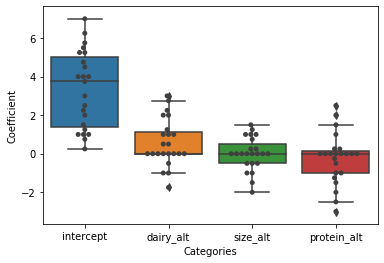

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(x="Categories", y="Coefficient", data=plot)
sns.swarmplot(x="Categories", y="Coefficient", data=plot, color=".25")
plt.savefig("Plot_final.png")

### Part 5: Simulate the Market
**Task 9:** Write a function `utility` that takes two arguments:
- `product`: a list of which level has been selected for each attribute.  For example, if the two attributes were color (with levels red and green) and shape (with levels round and square), then `product` could take the value `["red", "square"]`.
- `part_worths`: a row from the `individual_part_worths` data frame created for Task 6 (i.e., one individual's part-worths) .

The `utility` function should compute and return the utility of the specified individual for the specified product; this is the intercept plus any relevant part-worths that correspond to the product's attribute levels.

In [36]:
#####
# Product is diary, 16.9 oz, and has "Natural" protein
# The function is for all the respondents; however, if you want to use the function for a single respondent, then
# type utility(product, individual_part_worths.iloc[3]) <- choose whatever number you want
#####
product = ["Yes", "16.9 oz", "Natural"]
def utility(product, part_worths):
    if type(product) != list:
        raise TypeError("'Product' has to be a list")
    elif(len(product)) != 3:
        raise ValueError("'Product' has to have a length of 3")
    lst = product
    dataframe = part_worths
    dct = {'Yes':1,
    'No':0,
    '11 oz': 1,
    '16.9 oz':0,
    'Natural':1,
    'Synthetic':0
    }
    dct1 = {'Yes': 'dairy_alt',
    'No': 'dairy_alt',
    '11 oz': 'size_alt',
    '16.9 oz': 'size_alt',
    'Natural': 'protein_alt',
    'Synthetic':'protein_alt'
    }
    dataframe['utility'] = dataframe['intercept'] + dataframe[dct1[lst[0]]]*dct[lst[0]] +\
    dataframe[dct1[lst[1]]]*dct[lst[1]] + dataframe[dct1[lst[2]]]*dct[lst[2]]
    return dataframe[['Response ID', 'utility']]
utility(product, individual_part_worths)

,Response ID,utility
0,R_3qaqW0eYAJn1hOb,5.25
1,R_2wLGvRg9Y4EsjTu,5
2,R_1K22fncrFg6b19V,2.75
3,R_110HWkVnj3TyxKp,5.25
4,R_3PvOqFJvcxARm77,4
5,R_1OrUUvZ2npkkiQY,1
6,R_22DoMtTnvneHZt6,1
7,R_VKzQ0vXsTB7xra1,4
8,R_cZ4SgLfmwdPvI8F,5.25
9,R_1Io1cuIB1lYheOI,4.75


**Task 10:** Write a function `choose_product` that takes two arguments:
- `products`: a list of products, where each product is its own list as specified in Task 8, (Yes, it's a list of lists!)
- `part_worths`: a row of inidivudual part worths, just as used in Task 8.

This fuction should return a numpy array with the same length as the number of products; this array should contain a boolean value (true or false) for each product.  The value for a product should be true if it maximizes the utility for the individual; as multiple products can have equivalent utilities, more than one product might maximize utility.

As an example, if there are two products, the `choose_product` function could return `[True, False]` if the first product maximizes the utility, `[False, True]` if the second product maximizes utility, or `[True, True]` if both products have the same utility and therefor both maximize utility for specified the individual.

In [37]:
# I took four sets of products, but you can increase the number of products used
products = [["Yes", "16.9 oz", "Natural"],
           ["Yes", "16.9 oz", "Synthetic"],
           ["No", "16.9 oz", "Synthetic"],
           ["Yes", "16.9 oz", "Synthetic"]]
def  choose_product(products, part_worths):
    dct = {'Yes':1,
        'No':0,
        '11 oz': 1,
        '16.9 oz':0,
        'Natural':1,
        'Synthetic':0
        }
    dct1 = {'Yes': 'dairy_alt',
        'No': 'dairy_alt',
        '11 oz': 'size_alt',
        '16.9 oz': 'size_alt',
        'Natural': 'protein_alt',
        'Synthetic':'protein_alt'
        }
    uts = []
    for i in products:
        uts.append( part_worths['intercept'] + part_worths[dct1[i[0]]]*dct[i[0]] +\
        part_worths[dct1[i[1]]]*dct[i[1]] + part_worths[dct1[i[2]]]*dct[i[2]])
    uts1 = np.zeros((1, len(products)), dtype=bool)
    uts1[0][np.where(uts == np.max(uts))] = True
    return uts1
choose_product(products, individual_part_worths.iloc[3])
# You can change the number above (next to iloc) to get the values for each row of the dataset
# like if you take iloc[4] it will select the 5th row of the dataset

array([[False,  True, False,  True]])

**Task 11:** Write a function `simulate` that takes two arguments:
- `products`: a list of products, identitcal to the argument for Task 9.
- The `individual_part_worths` data frame created for Task 7.

This function should simulate the market share of the products by having each individual choose a product from the list.  For an individual who chooses more than one item (multiple items are tied for the top utility value), their "vote" is split between the tied items.  The function should return an array of proportions of market share.  

In [38]:
def simulate(products, individual_part_worths):
    dct = {'Yes':1,
        'No':0,
        '11 oz': 1,
        '16.9 oz':0,
        'Natural':1,
        'Synthetic':0
        }
    dct1 = {'Yes': 'dairy_alt',
        'No': 'dairy_alt',
        '11 oz': 'size_alt',
        '16.9 oz': 'size_alt',
        'Natural': 'protein_alt',
        'Synthetic':'protein_alt'
        }
    empty = np.zeros((1, len(products)))
    cnt = individual_part_worths.iloc[:, 0].count()
    for row in range(0, cnt):
        x = individual_part_worths.iloc[row,:]
        uts = []
        for i in products:
            uts.append( x['intercept'] + x[dct1[i[0]]]*dct[i[0]] +\
            x[dct1[i[1]]]*dct[i[1]] + x[dct1[i[2]]]*dct[i[2]])
        uts1 = np.zeros((1, len(products)))
        uts1[0][np.where(uts == np.max(uts))] =1/(cnt*len(np.where(uts == np.max(uts))[0]))
        empty += uts1
    return empty
simulate(products, individual_part_worths)

array([[0.2826087 , 0.23188406, 0.25362319, 0.23188406]])

**Task 12:** Create a variable called `my_product` that has the ideal value (maximum average utility) based on what you discovered in Task 5; this should be in the format described in Task 9.  For example, if the two attributes were color (with levels red and green) and shape (with levels round and square), then `my_product` could take the value `["red", "square"]`.  Also create three competitiors (e.g., `competitor1`) using this same format.  Create a list called `all_products` that contains all four products and simulate the market with the products.

In [42]:
my_product = ["Yes", "16.9 oz", "Synthetic"]
competitor1 = ["No", "16.9 oz", "Synthetic"]
competitor2 = ["Yes", "11 oz", "Natural"]
competitor3 = ["Yes", "16.9 oz", "Natural"]
all_products = [my_product, competitor1, competitor2, competitor3]
simulate(all_products, individual_part_worths)

array([[0.33695652, 0.25      , 0.31521739, 0.09782609]])

**Task 13:** Redefine `my_product` such that the most important attribute (from Task 6) now has the least liked level (per what you found in Task 5) and rerun the market simulation keeping the competitors the same.

In [44]:
my_product = ["Yes", "16.9 oz", "Natural"]
competitor1 = ["No", "16.9 oz", "Synthetic"]
competitor2 = ["Yes", "11 oz", "Natural"]
competitor3 = ["Yes", "16.9 oz", "Natural"]
all_products = [my_product, competitor1, competitor2, competitor3]
simulate(all_products, individual_part_worths)

array([[0.12681159, 0.37318841, 0.37318841, 0.12681159]])